# SNA
## Android malware detector

Authors:
- Nguyen Minh Tuan
- Le Dinh Nam
- Nguyen Thai Hung

In this file we searched for the optimal threshold for the best model from the previous steps (in this case - SVC).

In [ ]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets

# necessary paths
# feature_of_counts = "./data/processed_data/feature_vectors_counts.csv"
feature_of_counts = "./data/processed_data/new_transformation.csv"

# Random Seed for reproducible experiments
RS = 42
np.random.seed(RS)

In [ ]:
# data exploration
dataset = pd.read_csv(feature_of_counts, index_col=0)
display(dataset.head())

,access_network_state,action,activity,admob,android,api,api_call,app,call,category,...,org,permission,read_phone_state,real_permission,schemas,service_receiver,touchscreen,twitter,url,malware
0,0.073722,0.093886,0.305434,0.094639,0.390947,0.000000,0.074731,0.040295,0.127188,0.047015,...,0.0,0.148136,0.00000,0.050410,0.080769,0.090816,0.023049,0.0,0.499276,False
1,0.000000,0.033421,0.033454,0.000000,0.622147,0.000000,0.106407,0.000000,0.144879,0.033471,...,0.0,0.457008,0.12134,0.107665,0.000000,0.000000,0.032819,0.0,0.355452,False
2,0.000000,0.083183,0.249796,0.000000,0.489001,0.000000,0.176563,0.142803,0.090150,0.083309,...,0.0,0.087498,0.00000,0.089325,0.000000,0.000000,0.081686,0.0,0.491505,False
3,0.000000,0.027695,0.055445,0.614180,0.407026,0.120235,0.088178,0.000000,0.120060,0.027737,...,0.0,0.233057,0.00000,0.059481,0.095303,0.053579,0.027197,0.0,0.360017,False
4,0.000000,0.099619,0.498588,0.000000,0.585623,0.000000,0.105725,0.171019,0.107963,0.099770,...,0.0,0.104787,0.00000,0.106975,0.000000,0.192721,0.097826,0.0,0.000000,False


In [ ]:
num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

# Undersampling

benigware_indices = dataset[dataset.malware == False].index
benigware_indices_to_drop = np.random.choice(benigware_indices, num_beningware - num_malware, replace=False)
dataset = dataset.drop(benigware_indices_to_drop)

num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

X = dataset.drop(columns=['malware'])
y = dataset['malware']

# split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RS)

# preprocess data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
# evaluation metrics
def print_metrics(y_test, predicted):
	print("acc       {:.4}".format(metrics.accuracy_score(y_test, predicted)))
	print("f1        {:.4}".format(metrics.f1_score(y_test, predicted)))
	print("precision {:.4}".format(metrics.precision_score(y_test, predicted)))
	print("recall    {:.4}".format(metrics.recall_score(y_test, predicted)))


In [ ]:
# confusion matrix
def plot_conf_mat(y_test, predicted):
	conf_mat = metrics.confusion_matrix(y_test, predicted)

	# https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
	# Change figure size and increase dpi for better resolution
	plt.figure(figsize=(8,6), dpi=100)
	# Scale up the size of all text
	sns.set(font_scale = 1.1)

	# Plot Confusion Matrix using Seaborn heatmap()
	# Parameters:
	# first param - confusion matrix in array format
	# annot = True: show the numbers in each heatmap cell
	# fmt = 'd': show numbers as integers.
	ax = sns.heatmap(conf_mat, annot=True, fmt='d', )

	# set x-axis label and ticks.
	ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
	ax.xaxis.set_ticklabels(['Negative', 'Positive'])

	# set y-axis label and ticks
	ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
	ax.yaxis.set_ticklabels(['Negative', 'Positive'])

	# set plot title
	ax.set_title("Confusion Matrix", fontsize=14, pad=20)

	plt.show()

In [ ]:
# X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = RS)
#Split the training set into a training and a validation set.\
CV = 5
folds = KFold(n_splits=CV, random_state=42, shuffle=True)

In [ ]:
def Youden(y_test, predicted):
    conf_mat = metrics.confusion_matrix(y_test, predicted)
    TPR = conf_mat[1][1]
    TNR = conf_mat[0][0]
    FPR = conf_mat[1][0]
    FNR = conf_mat[0][1]
    J_index = TPR/(TPR+FNR+1) + TNR/(FPR+TNR+1) - 1 #Formula to calculate the Youden index
    return round(J_index,4)

def threshold(arr, t):
    new_arr = [0 for i in range(len(arr))]
    # Define the prediction for input based on this threshold
    for i in range(len(arr)):
        if arr[i][1] > t:
            new_arr[i] = 1
        else:
            new_arr[i] = 0
    # The new array will contain only 0s and 1s
    return new_arr

# Let's define all of the metrics
metric_list = [Youden, metrics.accuracy_score, metrics.f1_score]
metric_name = ['Youden index', 'Accuracy', 'F1 score']

In [ ]:
def best_model(metric, name):
    valid_metrics, train_metrics = [], []
    # The list of thresholds
    t_list = np.arange(0, 1, 0.05)
    print("Currently doing metric: {}".format(metric))

    for ii, (train_index, test_index) in enumerate(folds.split(X_train)):
        print("Current fold: {}".format(ii))
        # We create an instance of Neighbours Classifier and fit the data.
        clf = SVC(random_state=RS, C=10, kernel='rbf', probability=True)
        clf.fit(X_train.iloc[train_index], y_train.iloc[train_index])

        valid_tmp = []
        train_tmp = []
        for t in t_list:
            # Then we will predict on both training and validation sets
            predicted = threshold(clf.predict_proba(X_train.iloc[test_index]), t)
            y_train_pred = threshold(clf.predict_proba(X_train.iloc[train_index]), t)

            # Save the metric value
            valid = metric(y_train.iloc[test_index], predicted)
            train = metric(y_train.iloc[train_index], y_train_pred)

            valid_tmp.append(valid)
            train_tmp.append(train)

        valid_metrics.append(valid_tmp)
        train_metrics.append(train_tmp)

    valid_metrics = np.mean(np.array(valid_metrics), axis=0)
    train_metrics = np.mean(np.array(train_metrics), axis=0)

    find_max = np.array(valid_metrics)
    arg_max = np.argmax(valid_metrics)
    print("Maximum for {} is at index {}: {}, threshold: {}".format(metric, arg_max, find_max[arg_max], t_list[arg_max]))

    #Plot the metrics
    fig, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(t_list, train_metrics, color="blue", label='train')
    ax.plot(t_list, valid_metrics, color="red", label='valid')

    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel(name)
    ax.set_xticks(t_list[0:-1:2])
    ax.set_title('Train vs Validation Results')

Currently doing metric: <function Youden at 0x7f6f70f8fbe0>
Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Maximum for <function Youden at 0x7f6f70f8fbe0> is at index 11: 0.83962, threshold: 0.55
Currently doing metric: <function accuracy_score at 0x7f6f7196d990>
Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Maximum for <function accuracy_score at 0x7f6f7196d990> is at index 11: 0.9208626863974837, threshold: 0.55
Currently doing metric: <function f1_score at 0x7f6f7196dd80>
Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Maximum for <function f1_score at 0x7f6f7196dd80> is at index 11: 0.9208843139150685, threshold: 0.55


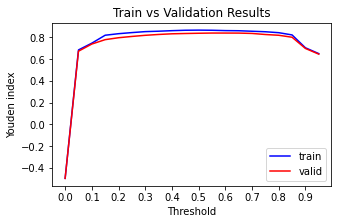

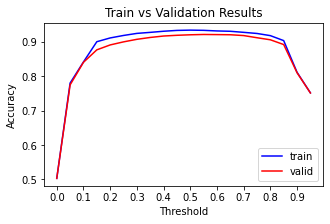

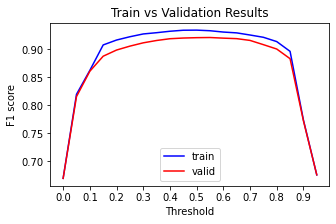

In [ ]:
for i in range(len(metric_list)):
    best_model(metric_list[i], metric_name[i])

In [ ]:
clf = SVC(random_state=RS, C=10, kernel='rbf', probability=True)
clf.fit(X_train, y_train)
y_test_pred = threshold(clf.predict_proba(X_test), 0.55)
print_metrics(y_test_pred, y_test)
print("youden   ", Youden(y_test_pred, y_test))

acc       0.9294
f1        0.9274
precision 0.9253
recall    0.9296
youden    0.8569


In [ ]:
metric_list